<a href="https://colab.research.google.com/github/satoruk-icepp/MEG2XEC/blob/master/MEG2Reg_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Overwriting .comet.config


In [3]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml
!pip install uproot

In [4]:
from comet_ml import Experiment
from comet_ml.exceptions import InterruptedExperiment
import time
import uproot
from datetime import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data.dataset import Subset
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.optimize import curve_fit

In [5]:
import sys
sys.path.append('/content/drive/My Drive/PySource/')
# from NetworkUtil import ResidualBlock,normal_init,Self_Attn,ResNetBasicBlock,ResNetLayer
from NetworkUtil import normal_init,Self_Attn,init_weights
from CosineExp import CosineExpLR
from InstanceNoise import add_instance_noise
from RandomScale import random_scale
from Test_Image import Make_Sample
# from Regressor_MEG import Regressor_MEG

In [6]:
experiment = Experiment(project_name="CWreg",log_code=True)
curtime = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment.set_name("%s"%(curtime))
params={'batch_size' : 200,
        'train_size':80000,
        'val_size':1000,
        'dropout_conv':0.3,
        'dropout_fc':0.0,
        'optim':"Adam",
        'weight_decay':1e-04,
        'Nresblock':5,
        'Nsd':0,
        'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        'ethreshold':0.0,
        'weightstd':1e-03,
        'Nlayer':16,
        'Nfc':0,
        'Nfcnodes':128,
        'Nepoch':5000,
        # 'Nepoch':10,
        # 'learning_rate':0.0000001,# for lr_test
        # 'LRgamma':10,# for lr_test
        # 'stepsize_lr':1, # for lr_test
        # "LRtype":"Step",
        'learning_rate':1e-4,
        'LRgamma':0.998,
        # 'LRgamma':1,
        # 'LRgamma':10,
        'milestones':[200,400,600,800,1000],
        # "LRtype":"MStep",
        # "LRtype":"Cyclic",
        # "LRtype":"CosA",
        "LRtype":"CosExp",
        # "LRtype":"Step",
        # "LRtype":"ROP",
        'noiselevel':1e-05,
        # 'stepsize_lr':50,
        'stepsize_lr':1,
        'stepsize_lr_down':29,
        'ene_reg':False,
        'pos_reg':True,
        'shw_reg':True,
        'base_lr':1e-8,# 10 nano
        'NphoScale':2e5,
        'UVWScale':[40,80,40],
        'SHWScale':[200,1,1],
        'ShowerLengthThreshold':2,
        # 'max_lr':0.005,
        'UsePMT':False,
        'UseLPF':False,
        'DoBlind':False,
        'UseBN':True
}
experiment.log_parameters(params)
if params["LRgamma"]>1:
    experiment.add_tag("LRTest")
if params["UseLPF"]:
    experiment.add_tag("LPF")
if params["pos_reg"]:
    experiment.add_tag("Pos")
if params["shw_reg"]:
    experiment.add_tag("Shw")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/cwreg/0aec6e72e499496483f0d576c350ee24



In [7]:
file = uproot.open("/content/drive/My Drive/MEG2CW/CWMC.root")
tout = file["tout"]

In [8]:
device = torch.device('cuda:0')

In [9]:
Energy  = tout.array("energy").reshape(-1,1)
EneREC  = tout.array("nsum2").reshape(-1,1)
UVW     = tout.array("uvw_MC").reshape(-1,3)
DIR     = tout.array("gamangle").reshape(-1,2)
SHW     = tout.array("shw_vec").reshape(-1,3)
UVWREC  = tout.array("uvw_rec").reshape(-1,3)
PMResponse = tout.array("Npho").reshape(-1,4760)

In [10]:
print(len(Energy))

86982


In [11]:
# plt.hist(PMResponse.reshape(-1))
# plt.yscale("log")
# plt.show()

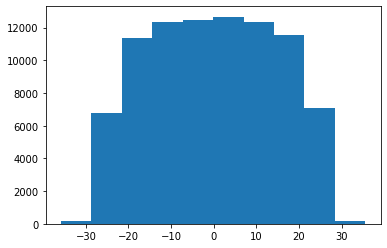

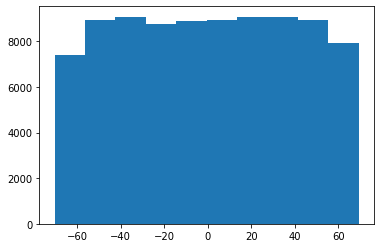

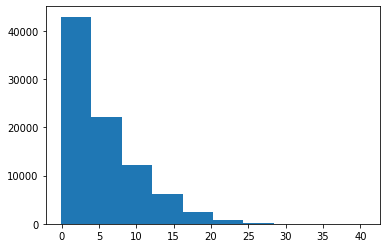

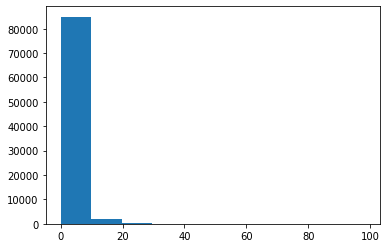

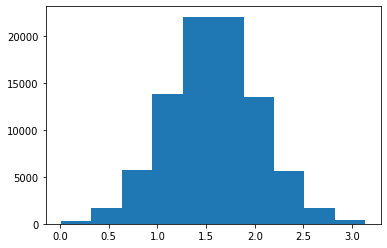

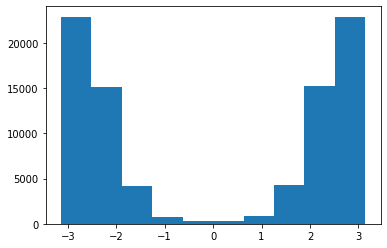

In [12]:
plt.hist(UVW[:,0])
plt.show()
plt.hist(UVW[:,1])
plt.show()
plt.hist(UVW[:,2])
plt.show()
plt.hist(SHW[:,0])
plt.show()
plt.hist(SHW[:,1])
plt.show()
plt.hist(SHW[:,2])
plt.show()

(array([1.4200e+02, 2.3000e+01, 4.5900e+02, 9.0700e+02, 2.1930e+03,
        7.7970e+03, 1.4828e+04, 6.0183e+04, 4.4400e+02, 6.0000e+00]),
 array([0.00219533, 0.11516247, 0.22812961, 0.34109676, 0.4540639 ,
        0.56703104, 0.67999818, 0.79296532, 0.90593247, 1.01889961,
        1.13186675]),
 <a list of 10 Patch objects>)

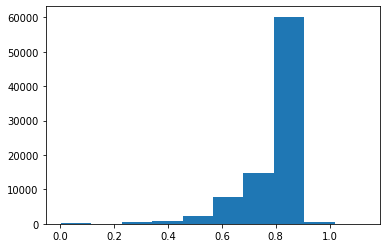

In [13]:
plt.hist(Energy)

(86982, 1)
(86982,)


(array([[1.0000e+01, 4.2000e+01, 4.1000e+01, 3.7000e+01, 9.0000e+00,
         3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 9.0000e+00, 6.0000e+00, 4.0000e+00, 3.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+01, 2.9100e+02, 1.3200e+02, 6.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 6.1000e+01, 4.4800e+02, 3.7700e+02, 1.7000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.9000e+01, 1.9500e+02, 8.2400e+02, 1.0830e+03,
         7.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.0000e+00, 1.3900e+02, 8.5300e+02, 2.7200e+03,
         3.7640e+03, 3.1700e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.5000e+01, 4.3500e+02, 1.9550e+03,
         4.7470e+03, 6.5520e+03, 1.1080e+03, 6.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

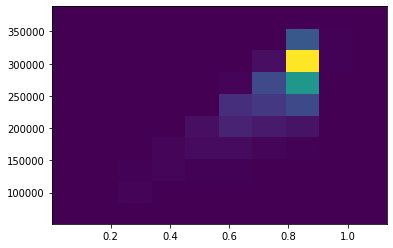

In [14]:
# print()
SumPMResponse = np.sum(PMResponse,axis=1)
print(Energy.shape)
print(SumPMResponse.shape)
plt.hist2d(Energy[:,0],SumPMResponse)

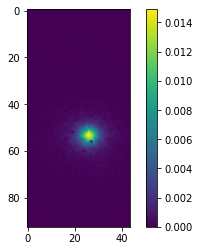

In [15]:
Energy     = Energy.reshape(-1,1)
EneREC     = EneREC.reshape(-1,1)

## Normalization 
PMResponse = PMResponse/params["NphoScale"]
UVW = UVW/params["UVWScale"]
SHW = SHW/params["SHWScale"]

PMResponse_MPPC,PMResponse_PMT = np.split(PMResponse,[4092],axis=1)
PMResponse_MPPC = PMResponse_MPPC.reshape(-1,93,44)

plt.imshow(PMResponse_MPPC[0])
plt.colorbar()
plt.show()

COSST = 0.5*np.cos(SHW[:,1]).reshape(-1,1)
SINST = 0.5*np.sin(SHW[:,1]).reshape(-1,1)
COSSP = 0.5*np.cos(SHW[:,2]).reshape(-1,1)
SINSP = 0.5*np.sin(SHW[:,2]).reshape(-1,1)
SHW = np.concatenate((SHW[:,0].reshape(-1,1),COSST,SINST,COSSP,SINSP),axis=1)
# print(ADD)

In [16]:
# del csv_data_numpy

In [17]:
PMResponse = PMResponse.reshape(-1,4760)
# PMResponse = PMResponse/PMResponseScale

In [18]:
Energy        = torch.tensor(Energy).float()
EneREC        = torch.tensor(EneREC).float()
UVW           = torch.tensor(UVW).float()
DIR           = torch.tensor(DIR).float()
SHW           = torch.tensor(SHW).float()
# ADD           = torch.tensor(ADD).float()
UVWREC        = torch.tensor(UVWREC).float()
PMResponse    = torch.tensor(PMResponse).float()

In [19]:
# from torch.utils.data.dataset import Subset
BATCH_SIZE = params["batch_size"]
calo_dataset    = utils.TensorDataset(Energy,EneREC,UVW,UVWREC,DIR,SHW,PMResponse)
data_size =  len(calo_dataset)
# full_size = int(data_size//1000)*1000
# val_size = 500
print(data_size)
# train_dataset = Subset(calo_dataset,list(range(0,full_size-val_size)))
# val_dataset = Subset(calo_dataset,list(range(full_size-val_size,full_size)))
train_dataset = Subset(calo_dataset,list(range(0,params["train_size"])))
val_dataset = Subset(calo_dataset,list(range(params["train_size"],params["train_size"]+params["val_size"])))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                            #   batch_size=BATCH_SIZE, 
                                             batch_size=len(val_dataset), 
                                              pin_memory=True, shuffle=True)


86982


In [20]:
class Regressor_simple(nn.Module):
    def __init__(self, Ndim_out,dropout_conv =0.0,dropout_fc=0.0,Nlayer=32,Nresblock=0,Nfcnodes=128,Ndim_cond=0):
        super(Regressor_simple, self).__init__()
        self.conv1 = nn.Conv2d(
            1, 
            Nlayer, 
            kernel_size=(7,6), 
            stride = (4,4), 
            padding = (3,3)
            )#(93+6,44+6)->24,12
        self.conv2 = nn.Conv2d(
            self.conv1.out_channels, 
            self.conv1.out_channels*2, 
            kernel_size=(4, 4), 
            stride=(2,2)
            ,padding = (1,1)
        )#24*12->12*6
        self.conv3 = nn.Conv2d(
            self.conv2.out_channels, 
            self.conv2.out_channels*2, 
            kernel_size=(2, 2), 
            stride=(2,2)
        )#12*6->6*3
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)
        self.bn3 = nn.BatchNorm2d(self.conv3.out_channels)
        Ndim_fcstart = self.conv3.out_channels*18+668
        self.fc1 = nn.Linear(Ndim_fcstart,Nfcnodes)
        self.fc2 = nn.Linear(self.fc1.out_features,1)
        self.dropout1 = nn.Dropout(dropout_conv)
        self.dropoutfc = nn.Dropout(dropout_fc)
        self.leakyReLU = nn.LeakyReLU(0.1)
        
    def forward(self, x, condition = None):
        x = x.view(x.shape[0],-1)
        x_mppc,x_pmt = torch.split(x,4092,dim=1)
        # x_mppc = self.MPPCforward(x_mppc)
        x_mppc = x_mppc.view(x_mppc.shape[0],1,93,44)
        x_mppc = self.leakyReLU(self.dropout1(self.bn1(self.conv1(x_mppc))))
        x_mppc = self.leakyReLU(self.dropout1(self.bn2(self.conv2(x_mppc))))
        x_mppc = self.leakyReLU(self.dropout1(self.bn3(self.conv3(x_mppc))))
        x_mppc = x_mppc.view(x_mppc.shape[0],self.conv3.out_channels*18)
        x = torch.cat([x_mppc,x_pmt],dim=1)
        x = self.leakyReLU(self.dropoutfc(self.fc1(x)))
        x = self.fc2(x)
        return torch.tanh(x)
        # return x

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    def eval_activate(self):
        model.eval()
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.track_running_stats=False

In [21]:
class Regressor_fc(nn.Module):
    def __init__(self, Ndim_out,dropout_conv =0.0,dropout_fc=0.0,Nlayer=32,Nresblock=0,Nfcnodes=128,Ndim_cond=0):
        super(Regressor_fc, self).__init__()
        self.fc1 = nn.Linear(4760,1)
        self.fc2 = nn.Linear(self.fc1.out_features,1)
        self.dropoutfc = nn.Dropout(dropout_fc)
        self.activation = nn.LeakyReLU(0.1)
        
    def forward(self, x, condition = None):
        x = x.view(x.shape[0],-1)
        # x_mppc,x_pmt = torch.split(x,4092,dim=1)
        # # x_mppc = self.MPPCforward(x_mppc)
        # x_mppc = x_mppc.view(x_mppc.shape[0],1,93,44)
        # x_mppc = F.relu(self.dropout1(self.conv1(x_mppc)))
        # x_mppc = F.relu(self.dropout1(self.conv2(x_mppc)))
        # x_mppc = x_mppc.view(x_mppc.shape[0],self.conv2.out_channels*72)
        # x = x_mppc
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return torch.tanh(x)
        # return x

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    def eval_activate(self):
        model.eval()
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.track_running_stats=False

In [22]:
Ndim_out = 0
if params["pos_reg"]:
    Ndim_out += 3
if params["shw_reg"]:
    Ndim_out += 5

Ndim_cond = 0
if params["UseLPF"]:
    Ndim_cond += 3

# model = Regressor_MEG(
#     Ndim_out,
#     params["dropout_conv"],
#     params["dropout_fc"],
#     params['Nlayer'],
#     params['Nresblock'],
#     params['Nfcnodes'],
#     Ndim_cond
#     ).to(device)
model = Regressor_simple(
    Ndim_out,
    params["dropout_conv"],
    params["dropout_fc"],
    params['Nlayer'],
    params['Nresblock'],
    params['Nfcnodes'],
    Ndim_cond
    ).to(device)    
# model = Regressor_fc(
#     Ndim_out,
#     params["dropout_conv"],
#     params["dropout_fc"],
#     params['Nlayer'],
#     params['Nresblock'],
#     params['Nfcnodes'],
#     Ndim_cond
#     ).to(device)    
print(model)
model.weight_init(mean=0.0, std=params['weightstd'])
# model.apply(init_weights)

Regressor_simple(
  (conv1): Conv2d(1, 16, kernel_size=(7, 6), stride=(4, 4), padding=(3, 3))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1820, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropoutfc): Dropout(p=0.0, inplace=False)
  (leakyReLU): LeakyReLU(negative_slope=0.1)
)


In [23]:
# learning_rate = 0.001
# opt = optim.Adam(regressor.parameters(), lr=learning_rate)
# opt = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
opt = optim.RMSprop(model.parameters(), lr=params["learning_rate"])
# if params["LRtype"]=="Cyclic":
#     scheduler = CyclicLR(opt, params["base_lr"],params["learning_rate"],
#                          step_size_up=params["stepsize_lr"],
#                          step_size_down=params["stepsize_lr_down"],
#                          cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
# elif params["LRtype"]=="MStep":
#     scheduler = MultiStepLR(opt, milestones=params["milestones"], gamma=params["LRgamma"])
# elif params["LRtype"]=="Step":
scheduler = StepLR(opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
# elif params["LRtype"]=="CosA":
#     scheduler = CosineAnnealingLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
# elif params["LRtype"]=="CosExp":
#     scheduler = CosineExpLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])
# elif params["LRtype"]=="ROP":
#     scheduler = ReduceLROnPlateau(opt,mode='min',factor=0.5,patience=params["stepsize_lr"])

In [24]:
Energy_mean, UVW_mean, DIR_mean,SHW_mean = Energy.mean(dim=0).to(device), UVW.mean(dim=0).to(device), DIR.mean(dim=0).to(device),SHW.mean(dim=0).to(device)
UVWE_mean = torch.cat([UVW_mean,Energy_mean]).to(device)
UVWESHW_mean = torch.cat([UVW_mean,Energy_mean,SHW_mean]).to(device)
UVWDIR_mean = torch.cat([UVW_mean, DIR_mean]).to(device)
def metric_relative_mse(y_pred,y_true):
    y_true_mean = y_true.mean(dim=0)
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWE_mean).pow(2).mean(dim=0)).sum()).sqrt()
    return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWESHW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true[:,2] - y_pred[:,2]).pow(2).mean(dim=0) / (y_true[:,2] - UVW_mean[2]).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWDIR_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - Energy_mean).pow(2).mean(dim=0)).sum()).sqrt()

In [25]:
loss_fn = torch.nn.SmoothL1Loss().to(device)
# loss_fn = torch.nn.L1Loss().to(device)

In [26]:
ranges=[2,2,5,5,1,1]
names = ["u","v","w","shwl","shwt","shwp"]
UVWScale = torch.tensor(params["UVWScale"]).to(device)
SHWScale = torch.tensor(params["SHWScale"]).to(device)
HalfPi = torch.tensor(math.pi/2.).to(device)

In [27]:

def Training(epoch):
    train_loss_array = []
    train_loss_eval_array = []
    ibatch = epoch*params["train_size"]/params["batch_size"]
    with experiment.train():
        for Energy_b, EneREC_b, UVW_b, UVWREC_b, DIR_b, SHW_b,  PMResponse_b in train_dataloader:
            # moving them to device(for example, cuda-device)
            Energy_b, EneREC_b, UVW_b, UVWREC_b, DIR_b, SHW_b,  PMResponse_b = Energy_b.to(device), \
                                            EneREC_b.to(device), \
                                            UVW_b.to(device), \
                                            UVWREC_b.to(device), \
                                            DIR_b.to(device), \
                                            SHW_b.to(device), \
                                            PMResponse_b.to(device)

    #             pred = regressor(EnergyDeposit_b)
            # model.train()
            # UVWDIR_b = torch.cat([UVW_b,DIR_b],dim=1)
            # UVWDIRrec_b = torch.cat([UVWREC_b,DIR_b],dim=1)
            # PMResponse_b = add_instance_noise(PMResponse_b,params["noiselevel"],device)
            # PMResponse_b = random_scale(PMResponse_b,0.3,device)
            pred = model(PMResponse_b)
            # print(PMResponse_b.sum(dim=0)[0])
            # print(pred)
            # if params["pos_reg"] and params["shw_reg"]:
            #     TGT_b = torch.cat([UVW_b,SHW_b],dim=1)
            # elif params["pos_reg"]:
            #     TGT_b = UVW_b
            # TGT_b = UVW_b
            TGT_b = Energy_b
            
            loss            = loss_fn(pred, TGT_b)
            # pred_shwt = torch.atan2(pred[:,4],pred[:,5]).view(-1,1)
            # pred_shwp = torch.atan2(pred[:,6],pred[:,7]).view(-1,1)
            # pred = torch.cat([pred[:,:4],pred_shwt,pred_shwp],dim=1)
            train_loss_array.append(loss.item())
            experiment.log_metric("batch_train_loss",loss.item(),step=ibatch)
            # if params["LRgamma"]>1:
            #     experiment.log_metric("batch_learning_rate", scheduler.get_lr(),step=ibatch)
            #     if scheduler.get_lr()[0]>1:
            #         return
            #     else:
            #         scheduler.step()
            opt.zero_grad()
            loss.backward()
            opt.step()
            ibatch=ibatch+1

        loss_avg = sum(train_loss_array)/len(train_loss_array)
        # loss_eval_avg = sum(train_loss_eval_array)/len(train_loss_eval_array)
        # if params["LRtype"] is not "ROP":
        learning_rate = scheduler.get_last_lr()
        scheduler.step()
        
        # else:
            # learning_rate = opt.param_groups[0]['lr']
        experiment.log_metric("train_loss",loss_avg ,step=epoch)
        # experiment.log_metric("train_loss_eval",loss_eval_avg ,step=epoch)
        # experiment.log_metric("learning_rate", scheduler.get_lr(),step=epoch)
        experiment.log_metric("learning_rate", learning_rate,step=epoch)
        
        


In [28]:

def Validation(epoch):
    val_loss_array = []
    with experiment.test():
        val_loss = 0
        for Energy_b, EneREC_b,  UVW_b, UVWREC_b, DIR_b, SHW_b,  PMResponse_b in val_dataloader:
            Energy_b, EneREC_b,  UVW_b, UVWREC_b, DIR_b, SHW_b,  PMResponse_b = Energy_b.to(device), \
                                            EneREC_b.to(device), \
                                            UVW_b.to(device), \
                                            UVWREC_b.to(device), \
                                            DIR_b.to(device), \
                                            SHW_b.to(device), \
                                            PMResponse_b.to(device)

            
            start_time = time.time()
            pred = model(PMResponse_b)
            
            
            end_time = time.time()
            inference_time = (end_time-start_time)/PMResponse_b.shape[0]
            TGT_b = Energy_b
            val_loss            = loss_fn(pred, TGT_b)
            val_loss_array.append(val_loss.item())
        val_loss_avg =  sum(val_loss_array)/len(val_loss_array)
        experiment.log_metric("val_loss",val_loss_avg,step=epoch)

            
        plt.figure(figsize=(35,12))
        grid = plt.GridSpec(2, pred.shape[1], wspace=0.4, hspace=0.3)
        plt.hist(Energy_b.cpu().detach().numpy(),histtype='step',range=(0,1),bins=100,fill=False,edgecolor='b')
        plt.hist(pred.cpu().detach().numpy(),histtype='step',range=(0,1),bins=100,fill=False,edgecolor='r')
        
        experiment.log_figure(figure=plt)
        plt.close()


In [29]:
# ranges=[2,2,4,2,3,50,50]

def run_training(epochs=100):
    # iterating over epochs...
    ibatch = 0
    for epoch in tqdm(range(epochs)):
        Training(epoch)
        Validation(epoch)
        # scheduler.step()
    

In [30]:
#  with experiment.train():
# experiment.log_code()
run_training(params["Nepoch"])


 25%|██▌       | 1259/5000 [1:23:44<4:03:28,  3.90s/it]

KeyboardInterrupt: ignored

In [31]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/satoruk-icepp/cwreg/0aec6e72e499496483f0d576c350ee24
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_val_loss [1259]            : (0.00035457356716506183, 0.0032983925193548203)
COMET INFO:     train_batch_train_loss [503949] : (0.00011293535499135032, 0.3403891921043396)
COMET INFO:     train_learning_rate [1259]      : (8.05788267244349e-06, 0.0001)
COMET INFO:     train_loss [50394]              : (0.00012849755876231939, 0.31519460678100586)
COMET INFO:     train_train_loss [1259]         : (0.0003004873700047028, 0.03511841136263683)
COMET INFO:   Others:
COMET INFO:     Name : 20200924-191924
COMET INFO:   Parameters:
COMET INFO:     DoBlind               : 1
COMET INFO:     LRgamma               : 0.998
COMET INFO:     LRtype

In [33]:
dummy_input = torch.randn((1, 4760)).cuda()
torch.onnx.export(model, dummy_input, "meg2enereg.onnx", verbose=True)

graph(%0 : Float(1:4760, 4760:1),
      %conv1.weight : Float(16:42, 1:42, 7:6, 6:1),
      %conv1.bias : Float(16:1),
      %conv2.weight : Float(32:256, 16:16, 4:4, 4:1),
      %conv2.bias : Float(32:1),
      %conv3.weight : Float(64:128, 32:4, 2:2, 2:1),
      %conv3.bias : Float(64:1),
      %bn1.weight : Float(16:1),
      %bn1.bias : Float(16:1),
      %bn1.running_mean : Float(16:1),
      %bn1.running_var : Float(16:1),
      %bn2.weight : Float(32:1),
      %bn2.bias : Float(32:1),
      %bn2.running_mean : Float(32:1),
      %bn2.running_var : Float(32:1),
      %bn3.weight : Float(64:1),
      %bn3.bias : Float(64:1),
      %bn3.running_mean : Float(64:1),
      %bn3.running_var : Float(64:1),
      %fc1.weight : Float(128:1820, 1820:1),
      %fc1.bias : Float(128:1),
      %fc2.weight : Float(1:128, 128:1),
      %fc2.bias : Float(1:1),
      %70 : Long(1:1),
      %71 : Long(1:1),
      %72 : Long(1:1),
      %73 : Long(1:1),
      %74 : Long(1:1)):
  %26 : Tensor = onnx

In [35]:
!pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 2.8MB/s 
     |████████████████████████████████| 4.4MB 43.2MB/s 


In [36]:
import onnx

onnx_model = onnx.load("meg2enereg.onnx")
onnx.checker.check_model(onnx_model)

In [38]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("meg2enereg.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(PMResponse[0]).reshape(1,4760)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs,Energy[0])

[array([[0.8672646]], dtype=float32)] tensor([0.8810])
